In [1]:
#!pip install tensorflow

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

# Define dataset root path
data_dir = r"C:\Users\Prathamesh\Downloads\Projects\Deepfake Detection Model\DeepFakeDetectionDataset"
batch_size = 32
img_size = (128, 128)  # Resize images

# Load train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, "train"),
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary",  # Binary classification (Real vs Fake)
    shuffle=True
)

# Load validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, "validation"),
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary",
    shuffle=False
)

# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, "test"),
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary",
    shuffle=False
)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Apply data augmentation to training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Normalize images (rescale pixel values to [0,1])
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch to improve performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.


In [4]:
from tensorflow.keras import layers, models, regularizers

# Build CNN model
model = models.Sequential([
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Flatten layer
    layers.Flatten(),
    
    # Fully Connected Layer
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # 50% of neurons will be dropped
    layers.BatchNormalization(),

    # Output Layer
    layers.Dense(1, activation='sigmoid')  # Binary Classification (Real vs Fake)
])


C:\Users\Prathamesh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Show model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,177 (12.61 MB)

 Trainable params: 3,305,473 (12.61 MB)

 Non-trainable params: 704 (2.75 KB)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("deepfake_best_model.h5", save_best_only=True)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]  # Use callbacks
)

Epoch 1/20
4375/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.6604 - loss: 0.9360

4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1201s 273ms/step - accuracy: 0.6605 - loss: 0.9359 - val_accuracy: 0.8303 - val_loss: 0.7542
Epoch 2/20
4375/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8475 - loss: 0.7126

4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1061s 242ms/step - accuracy: 0.8475 - loss: 0.7126 - val_accuracy: 0.8616 - val_loss: 0.6371
Epoch 3/20
4375/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8770 - loss: 0.5883

4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1096s 241ms/step - accuracy: 0.8770 - loss: 0.5883 - val_accuracy: 0.8763 - val_loss: 0.5506
Epoch 4/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1056s 241ms/step - accuracy: 0.8872 - loss: 0.5214 - val_accuracy: 0.8360 - val_loss: 0.6209
Epoch 5/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1047s 239ms/step - accuracy: 0.8920 - loss: 0.5048 - val_accuracy: 0.8432 - val_loss: 0.5924
Epoch 6/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1050s 240ms/step - accuracy: 0.8926 - loss: 0.4947 - val_accuracy: 0.8544 - val_loss: 0.5735
Epoch 7/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1043s 238ms/step - accuracy: 0.8947 - loss: 0.4817 - val_accuracy: 0.8304 - val_loss: 0.6295
Epoch 8/20
4375/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8926 - loss: 0.4958

4376/4376 ━━━━━━━━━━━━━━━━━━━━ 987s 225ms/step - accuracy: 0.8926 - loss: 0.4958 - val_accuracy: 0.8641 - val_loss: 0.5157
Epoch 9/20
4375/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9002 - loss: 0.4576

4376/4376 ━━━━━━━━━━━━━━━━━━━━ 966s 221ms/step - accuracy: 0.9002 - loss: 0.4576 - val_accuracy: 0.8796 - val_loss: 0.5037
Epoch 10/20
4375/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9022 - loss: 0.4474

4376/4376 ━━━━━━━━━━━━━━━━━━━━ 960s 219ms/step - accuracy: 0.9022 - loss: 0.4474 - val_accuracy: 0.8686 - val_loss: 0.5035
Epoch 11/20
4375/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8770 - loss: 0.5363

4376/4376 ━━━━━━━━━━━━━━━━━━━━ 959s 219ms/step - accuracy: 0.8770 - loss: 0.5362 - val_accuracy: 0.8957 - val_loss: 0.4570
Epoch 12/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 959s 219ms/step - accuracy: 0.9004 - loss: 0.4493 - val_accuracy: 0.8721 - val_loss: 0.5293
Epoch 13/20
4375/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9032 - loss: 0.4404

4376/4376 ━━━━━━━━━━━━━━━━━━━━ 958s 219ms/step - accuracy: 0.9032 - loss: 0.4404 - val_accuracy: 0.8941 - val_loss: 0.4506
Epoch 14/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1003s 229ms/step - accuracy: 0.9022 - loss: 0.4386 - val_accuracy: 0.8809 - val_loss: 0.4743
Epoch 15/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1008s 230ms/step - accuracy: 0.9040 - loss: 0.4341 - val_accuracy: 0.8787 - val_loss: 0.4885
Epoch 16/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 971s 222ms/step - accuracy: 0.9051 - loss: 0.4305 - val_accuracy: 0.8860 - val_loss: 0.4609
Epoch 17/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 962s 220ms/step - accuracy: 0.9040 - loss: 0.4334 - val_accuracy: 0.8407 - val_loss: 0.5971
Epoch 18/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 966s 221ms/step - accuracy: 0.9036 - loss: 0.4358 - val_accuracy: 0.8871 - val_loss: 0.4631


In [6]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

341/341 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.8616 - loss: 0.5156
Test Accuracy: 0.8376


In [7]:
model.save("deepfake_detection_model.h5")  # Saves the model in HDF5 format

In [5]:
from tensorflow.keras.models import load_model

model = load_model("deepfake_detection_model.h5")

341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step


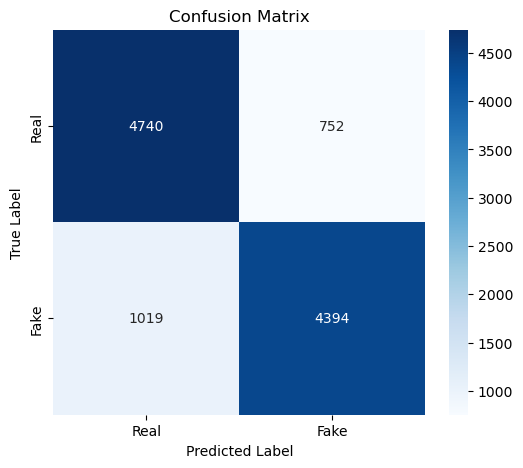

              precision    recall  f1-score   support

        Real       0.82      0.86      0.84      5492
        Fake       0.85      0.81      0.83      5413

    accuracy                           0.84     10905
   macro avg       0.84      0.84      0.84     10905
weighted avg       0.84      0.84      0.84     10905



In [6]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels and predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)  # Actual labels
y_pred_probs = model.predict(test_ds)  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype("int32")  # Convert to binary predictions (0 or 1)

# **Step 2: Compute Confusion Matrix**
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# **Step 3: Print Classification Report**
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))

In [21]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the trained model
model = tf.keras.models.load_model("deepfake_detection_model.h5")  # Ensure correct path

# Load and preprocess a test image
img_path = r"C:\Users\Prathamesh\Downloads\DF image.jpg"  # CHANGE THIS to an actual image path
img_size = (128, 128)  # Same size used during training
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict
prediction = model.predict(img_array)
print(f"Prediction Score: {prediction[0][0]}")

# Interpret results
threshold = 0.5  # Assuming binary classification
if prediction[0][0] >= threshold:
    print("Real Image")  # Flip labels
else:
    print("Fake Image")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Prediction Score: 0.9943521618843079
Real Image
